## Copyright 2022 Google LLC. Double-click for license information.

In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
print("GPU Available:", tf.config.list_physical_devices('GPU'))


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!pip install transformers
!pip install ftfy
!pip install opencv-python
!pip install ipywidgets
!pip install accelerate
!pip install torch torchvision torchaudio
!pip install tensorflow
!pip install scipy fire safetensors mediapipe
!nvidia-smi
!pip install diffusers==0.15.0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Prompt2Prompt')  # Add the folder containing ptp_utils.py to the Python path


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Prompt-to-Prompt with Stable Diffusion

In [ ]:
from typing import Optional, Union, Tuple, List, Callable, Dict
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from huggingface_hub import model_info
import torch.nn.functional as nnf
import numpy as np
import abc
import ptp_utils
import seq_aligner

For loading the Stable Diffusion using Diffusers, follow the instuctions https://huggingface.co/blog/stable_diffusion and update ```MY_TOKEN``` with your token.
Set ```LOW_RESOURCE``` to ```True``` for running on 12GB GPU.

In [ ]:
MY_TOKEN = #<your_token>
LOW_RESOURCE = True
NUM_DIFFUSION_STEPS = 50
GUIDANCE_SCALE = 7.5
#MAX_NUM_WORDS = 120
MAX_NUM_WORDS = 77
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

model_path="SujinHwang/criminal-sketch-lora-v1-6"
info = model_info(model_path)
model_base = info.cardData["base_model"]
print(model_base)

criminal-sketch-lora-v1-5


In [ ]:
ldm_stable = StableDiffusionPipeline.from_pretrained("Bingsu/my-korean-stable-diffusion-v1-5", torch_dtype=torch.float32, use_auth_token=MY_TOKEN).to(device)
ldm_stable.scheduler = DPMSolverMultistepScheduler.from_config(ldm_stable.scheduler.config)
#ldm_stable.unet.load_attn_procs(model_path)
ldm_stable.load_lora_weights(model_path)
ldm_stable.to("cuda")
tokenizer = ldm_stable.tokenizer

text_encoder/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


/usr/local/lib/python3.10/dist-packages/diffusers/loaders.py:783: FutureWarning: You have saved the LoRA weights using the old format. This will be
  deprecate("legacy LoRA weights", "1.0.0", deprecation_message, standard_warn=False)


In [ ]:
!nvidia-smi

Thu Nov  9 08:51:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W /  70W |   6225MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Prompt-to-Prompt Attnetion Controllers
Our main logic is implemented in the `forward` call in an `AttentionControl` object.
The forward is called in each attention layer of the diffusion model and it can modify the input attnetion weights `attn`.

`is_cross`, `place_in_unet in ("down", "mid", "up")`, `AttentionControl.cur_step` help us track the exact attention layer and timestamp during the diffusion iference.


In [ ]:
class LocalBlend:

    def __call__(self, x_t, attention_store):
        k = 1
        maps = attention_store["down_cross"][2:4] + attention_store["up_cross"][:3]
        maps = [item.reshape(self.alpha_layers.shape[0], -1, 1, 16, 16, MAX_NUM_WORDS) for item in maps]
        maps = torch.cat(maps, dim=1)
        maps = (maps * self.alpha_layers).sum(-1).mean(1)
        mask = nnf.max_pool2d(maps, (k * 2 + 1, k * 2 +1), (1, 1), padding=(k, k))
        mask = nnf.interpolate(mask, size=(x_t.shape[2:]))
        mask = mask / mask.max(2, keepdims=True)[0].max(3, keepdims=True)[0]
        mask = mask.gt(self.threshold)
        mask = (mask[:1] + mask[1:]).float()
        x_t = x_t[:1] + mask * (x_t - x_t[:1])
        return x_t

    def __init__(self, prompts: List[str], words: [List[List[str]]], threshold=.3):
        alpha_layers = torch.zeros(len(prompts),  1, 1, 1, 1, MAX_NUM_WORDS)
        for i, (prompt, words_) in enumerate(zip(prompts, words)):
            if type(words_) is str:
                words_ = [words_]
            for word in words_:
                ind = ptp_utils.get_word_inds(prompt, word, tokenizer)
                alpha_layers[i, :, :, :, :, ind] = 1
        self.alpha_layers = alpha_layers.to(device)
        self.threshold = threshold


class AttentionControl(abc.ABC):

    def step_callback(self, x_t):
        return x_t

    def between_steps(self):
        return

    @property
    def num_uncond_att_layers(self):
        return self.num_att_layers if LOW_RESOURCE else 0

    @abc.abstractmethod
    def forward (self, attn, is_cross: bool, place_in_unet: str):
        raise NotImplementedError

    def __call__(self, attn, is_cross: bool, place_in_unet: str):
        if self.cur_att_layer >= self.num_uncond_att_layers:
            if LOW_RESOURCE:
                attn = self.forward(attn, is_cross, place_in_unet)
            else:
                h = attn.shape[0]
                attn[h // 2:] = self.forward(attn[h // 2:], is_cross, place_in_unet)
        self.cur_att_layer += 1
        if self.cur_att_layer == self.num_att_layers + self.num_uncond_att_layers:
            self.cur_att_layer = 0
            self.cur_step += 1
            self.between_steps()
        return attn

    def reset(self):
        self.cur_step = 0
        self.cur_att_layer = 0

    def __init__(self):
        self.cur_step = 0
        self.num_att_layers = -1
        self.cur_att_layer = 0

class EmptyControl(AttentionControl):

    def forward (self, attn, is_cross: bool, place_in_unet: str):
        return attn


class AttentionStore(AttentionControl):

    @staticmethod
    def get_empty_store():
        return {"down_cross": [], "mid_cross": [], "up_cross": [],
                "down_self": [],  "mid_self": [],  "up_self": []}

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        key = f"{place_in_unet}_{'cross' if is_cross else 'self'}"
        if attn.shape[1] <= 32 ** 2:  # avoid memory overhead
            self.step_store[key].append(attn)
        return attn

    def between_steps(self):
        if len(self.attention_store) == 0:
            self.attention_store = self.step_store
        else:
            for key in self.attention_store:
                for i in range(len(self.attention_store[key])):
                    self.attention_store[key][i] += self.step_store[key][i]
        self.step_store = self.get_empty_store()

    def get_average_attention(self):
        average_attention = {key: [item / self.cur_step for item in self.attention_store[key]] for key in self.attention_store}
        return average_attention


    def reset(self):
        super(AttentionStore, self).reset()
        self.step_store = self.get_empty_store()
        self.attention_store = {}

    def __init__(self):
        super(AttentionStore, self).__init__()
        self.step_store = self.get_empty_store()
        self.attention_store = {}


class AttentionControlEdit(AttentionStore, abc.ABC):

    def step_callback(self, x_t):
        if self.local_blend is not None:
            x_t = self.local_blend(x_t, self.attention_store)
        return x_t

    def replace_self_attention(self, attn_base, att_replace):
        if att_replace.shape[2] <= 16 ** 2:
            return attn_base.unsqueeze(0).expand(att_replace.shape[0], *attn_base.shape)
        else:
            return att_replace

    @abc.abstractmethod
    def replace_cross_attention(self, attn_base, att_replace):
        raise NotImplementedError

    def forward(self, attn, is_cross: bool, place_in_unet: str):
        super(AttentionControlEdit, self).forward(attn, is_cross, place_in_unet)
        if is_cross or (self.num_self_replace[0] <= self.cur_step < self.num_self_replace[1]):
            h = attn.shape[0] // (self.batch_size)
            attn = attn.reshape(self.batch_size, h, *attn.shape[1:])
            attn_base, attn_repalce = attn[0], attn[1:]
            if is_cross:
                alpha_words = self.cross_replace_alpha[self.cur_step]
                attn_repalce_new = self.replace_cross_attention(attn_base, attn_repalce) * alpha_words + (1 - alpha_words) * attn_repalce
                attn[1:] = attn_repalce_new
            else:
                attn[1:] = self.replace_self_attention(attn_base, attn_repalce)
            attn = attn.reshape(self.batch_size * h, *attn.shape[2:])
        return attn

    def __init__(self, prompts, num_steps: int,
                 cross_replace_steps: Union[float, Tuple[float, float], Dict[str, Tuple[float, float]]],
                 self_replace_steps: Union[float, Tuple[float, float]],
                 local_blend: Optional[LocalBlend]):
        super(AttentionControlEdit, self).__init__()
        self.batch_size = len(prompts)
        self.cross_replace_alpha = ptp_utils.get_time_words_attention_alpha(prompts, num_steps, cross_replace_steps, tokenizer).to(device)
        if type(self_replace_steps) is float:
            self_replace_steps = 0, self_replace_steps
        self.num_self_replace = int(num_steps * self_replace_steps[0]), int(num_steps * self_replace_steps[1])
        self.local_blend = local_blend

class AttentionReplace(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        return torch.einsum('hpw,bwn->bhpn', attn_base, self.mapper)

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionReplace, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper = seq_aligner.get_replacement_mapper(prompts, tokenizer).to(device)


class AttentionRefine(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        attn_base_replace = attn_base[:, :, self.mapper].permute(2, 0, 1, 3)
        attn_replace = attn_base_replace * self.alphas + att_replace * (1 - self.alphas)
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float,
                 local_blend: Optional[LocalBlend] = None):
        super(AttentionRefine, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.mapper, alphas = seq_aligner.get_refinement_mapper(prompts, tokenizer)
        self.mapper, alphas = self.mapper.to(device), alphas.to(device)
        self.alphas = alphas.reshape(alphas.shape[0], 1, 1, alphas.shape[1])


class AttentionReweight(AttentionControlEdit):

    def replace_cross_attention(self, attn_base, att_replace):
        if self.prev_controller is not None:
            attn_base = self.prev_controller.replace_cross_attention(attn_base, att_replace)
        attn_replace = attn_base[None, :, :, :] * self.equalizer[:, None, None, :]
        return attn_replace

    def __init__(self, prompts, num_steps: int, cross_replace_steps: float, self_replace_steps: float, equalizer,
                local_blend: Optional[LocalBlend] = None, controller: Optional[AttentionControlEdit] = None):
        super(AttentionReweight, self).__init__(prompts, num_steps, cross_replace_steps, self_replace_steps, local_blend)
        self.equalizer = equalizer.to(device)
        self.prev_controller = controller


def get_equalizer(text: str, word_select: Union[int, Tuple[int, ...]], values: Union[List[float],
                  Tuple[float, ...]]):
    if type(word_select) is int or type(word_select) is str:
        word_select = (word_select,)
    equalizer = torch.ones(len(values), MAX_NUM_WORDS)
    #equalizer = torch.ones(len(values), 77)
    values = torch.tensor(values, dtype=torch.float32)
    for word in word_select:
        inds = ptp_utils.get_word_inds(text, word, tokenizer)
        equalizer[:, inds] = values
    return equalizer


In [ ]:
from PIL import Image

def aggregate_attention(attention_store: AttentionStore, res: int, from_where: List[str], is_cross: bool, select: int):
    out = []
    attention_maps = attention_store.get_average_attention()
    num_pixels = res ** 2
    for location in from_where:
        for item in attention_maps[f"{location}_{'cross' if is_cross else 'self'}"]:
            if item.shape[1] == num_pixels:
                cross_maps = item.reshape(len(prompts), -1, res, res, item.shape[-1])[select]
                out.append(cross_maps)
    out = torch.cat(out, dim=0)
    out = out.sum(0) / out.shape[0]
    return out.cpu()


def show_cross_attention(attention_store: AttentionStore, res: int, from_where: List[str], select: int = 0):
    tokens = tokenizer.encode(prompts[select])
    print(len(tokens))
    decoder = tokenizer.decode
    attention_maps = aggregate_attention(attention_store, res, from_where, True, select)
    images = []
    for i in range(len(tokens)):
        image = attention_maps[:, :, i]
        image = 255 * image / image.max()
        image = image.unsqueeze(-1).expand(*image.shape, 3)
        image = image.numpy().astype(np.uint8)
        image = np.array(Image.fromarray(image).resize((256, 256)))
        image = ptp_utils.text_under_image(image, decoder(int(tokens[i])))
        images.append(image)
    ptp_utils.view_images(np.stack(images, axis=0))


def show_self_attention_comp(attention_store: AttentionStore, res: int, from_where: List[str],
                        max_com=10, select: int = 0):
    attention_maps = aggregate_attention(attention_store, res, from_where, False, select).numpy().reshape((res ** 2, res ** 2))
    u, s, vh = np.linalg.svd(attention_maps - np.mean(attention_maps, axis=1, keepdims=True))
    images = []
    for i in range(max_com):
        image = vh[i].reshape(res, res)
        image = image - image.min()
        image = 255 * image / image.max()
        image = np.repeat(np.expand_dims(image, axis=2), 3, axis=2).astype(np.uint8)
        image = Image.fromarray(image).resize((256, 256))
        image = np.array(image)
        images.append(image)
    ptp_utils.view_images(np.concatenate(images, axis=1))

In [ ]:
def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")
    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)
    ptp_utils.view_images(images)
    return images, x_t

In [ ]:
import time

def run_and_display(prompts, controller, latent=None, run_baseline=False, generator=None):
    # Record the start time
    start_time = time.time()

    if run_baseline:
        print("w.o. prompt-to-prompt")
        images, latent = run_and_display(prompts, EmptyControl(), latent=latent, run_baseline=False, generator=generator)
        print("with prompt-to-prompt")

    images, x_t = ptp_utils.text2image_ldm_stable(ldm_stable, prompts, controller, latent=latent, num_inference_steps=NUM_DIFFUSION_STEPS, guidance_scale=GUIDANCE_SCALE, generator=generator, low_resource=LOW_RESOURCE)

    # Record the end time
    end_time = time.time()

    # Calculate and print the elapsed time
    elapsed_time = end_time - start_time
    print(f"Time taken: {elapsed_time:.2f} seconds")

    ptp_utils.view_images(images)
    return images, x_t


## Cross-Attention Visualization
First let's generate an image and visualize the cross-attention maps for each word in the prompt.
Notice, we normalize each map to 0-1.

  0%|          | 0/50 [00:00<?, ?it/s]

Time taken: 29.51 seconds


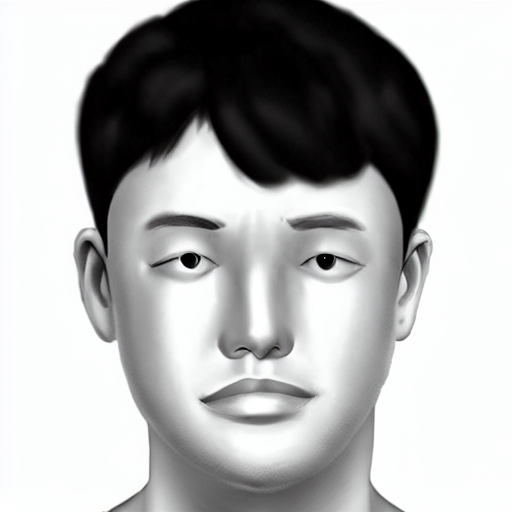

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 볼이 넓은 계란형 얼굴이며 앞머리가 이마의 양쪽 끝을 가리고 있어 모양은 보이지 않는다. \
오른쪽 턱의 각진 부분이 왼쪽에 비해 아래로 내려와 있고 왼쪽은 약간 완만한 형태이다. \
턱끝으로 내려오는 턱모양은 약간 둥근형으로 보인다. 왼쪽의 볼이 더 평평하고 넓은 편이다. "]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

  0%|          | 0/50 [00:00<?, ?it/s]

Time taken: 27.09 seconds


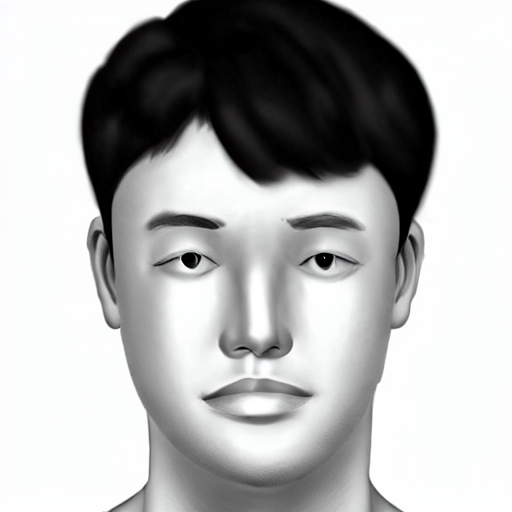

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 볼이 넓은 계란형 얼굴이며 앞머리가 이마의 양쪽 끝을 가리고 있어 모양은 보이지 않는다. \
오른쪽 턱의 각진 부분이 왼쪽에 비해 아래로 내려와 있고 왼쪽은 약간 완만한 형태이다. \
턱이 뾰쪽하다. 왼쪽의 볼이 더 평평하고 넓은 편이다. "]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

  0%|          | 0/50 [00:00<?, ?it/s]

Time taken: 27.67 seconds


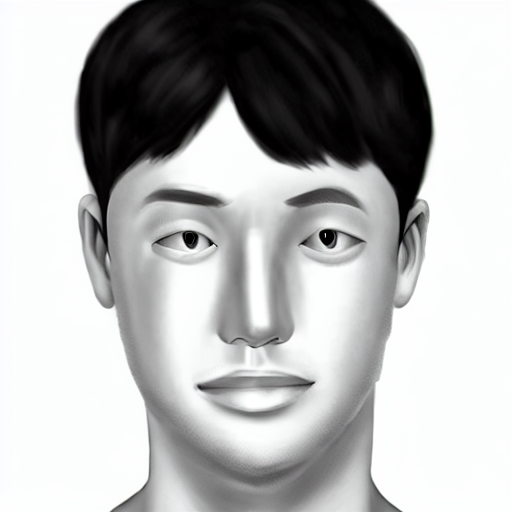

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 왼쪽 눈꼬리 밑에 점이 있다. 볼이 넓은 계란형 얼굴이며 앞머리가 이마의 양쪽 끝을 가리고 있어 모양은 보이지 않는다. \
오른쪽 턱의 각진 부분이 왼쪽에 비해 아래로 내려와 있고 왼쪽은 약간 완만한 형태이다. \
턱끝으로 내려오는 턱모양은 약간 둥근형으로 보인다. 왼쪽의 볼이 더 평평하고 넓은 편이다. "]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 미소 짓고있는 웃는 모습으로 매력적으로 보임. \
선한 인상의 눈을 가지고 있어 순수해보이고, 착해보이지만 반대로 속을 알 수 없는 듯한 가식적인 모습으로 보이기도 하는 이중적인 모습을 보여주고 있음."]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 큰 얼굴 얇은 입술 이마 주름 M자 탈모 웃는 주걱턱 통통한 볼살 일자 눈썹 작은 눈"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 턱이 뾰족하고 입술은 얇다. 2:8 가르마를 탔으며 머리는 풍성하다. 웃는 인상이며 주걱턱이고 팔자주름이 있고 볼살은 통통한 편이다. 일자 눈썹에 째진 눈이다. 오른쪽 볼에 점이 있다."]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

In [ ]:
g_cpu = torch.Generator().manual_seed(8888)
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["남성. 전체적으로 얼굴이 단단하고 다부진 형태로 매사에 공격적인 성격으로 보여짐 \
육체 골격도 상당히 클 것으로 보이고 건장한 신체를 활용한 직업군에 있을 것으로 보임 평상시에는 말을 잘 안하는 조용한 성격으로 보여짐"]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))

In [ ]:
g_cpu = torch.Generator().manual_seed(1111)
# 1111, 4444, 1234, 1248, 9999 모두 형태가 무너지는 결과를 보임
#prompts = ["A painting of a squirrel eating a burger"]
prompts = ["미소 짓고있는 웃는 모습으로 매력적으로 보임. 선한 인상의 눈을 가지고 있어 순수해보이고, 착해보이지만 반대로 속을 알 수 없는 듯한 가식적인 모습으로 보이기도 하는 이중적인 모습을 보여주고 있음."]
controller = AttentionStore()
image, x_t = run_and_display(prompts, controller, latent=None, run_baseline=False, generator=g_cpu)
#show_cross_attention(controller, res=16, from_where=("up", "down"))